# [1주차] 기본과제 - MNIST를 분류 모델로 학습하기

## Test data 준비하기
- Test data는 MNIST의 train data를 load하는 코드에서 train=False로 두면 됩니다.
- Train data와 마찬가지로 test data에 대한 data loader를 생성해주시면 됩니다(batch size는 동일하게 적용).
- Test data는 랜덤하게 섞일 필요가 없기 때문에 shuffle=False로 설정합니다.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

In [ ]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

## nn.CrossEntropyLoss 적용하기
- 현재 코드는 regression model을 구현한 상태로, MSE를 loss로 사용하고 있습니다.
- 하지만 MNIST와 같은 분류 문제에서는 MSE는 적합하지 않습니다.
  - MSE에 따르면 1에 해당하는 손글씨 이미지는 7에 해당하는 손글씨 이미지보다 0에 해당하는 손글씨 이미지가 더 가깝게 여겨집니다.
  - 하지만 1은 실제로 0보다 7과 더 비슷하게 생겼습니다.
- 일반적으로 분류 문제는 MSE 대신 cross entropy loss를 사용합니다.
- PyTorch에서의 cross entropy loss 문서 또는 웹 자료들을 통해 이해한 후, MSE를 대체하는 코드를 구현하시면 됩니다.
  - 변경되어야 할 점은 2가지
    - i) Model의 최종 output의 dimension과
    - ii) loss 계산 부분입니다.

In [ ]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()

        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)

        self.act = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.act(self.layer3(x))

        return x

In [ ]:
from torch.optim import SGD

model = Model(28 * 28 * 1, 1024).to("cuda")

lr = 0.001
optimizer = SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        preds = model(inputs)
        preds = torch.argmax(preds, dim=-1)

        cnt += labels.shape[0]
        acc += (labels == preds).sum().item()

    return acc / cnt

## 학습을 진행한 후, epoch에 따른 model의 train과 test data에 대한 정확도 plot하기
- 다음 조건들 아래에서 학습을 진행하면 됩니다.
  - n_epochs=100, batch_size=256, lr=0.001.
- 어떤 dataloader에 대한 model의 정확도를 측정하는 코드는 다음 함수를 사용하시면 됩니다:
- 추가적으로 구현되어야 하는 부분들을 요약하면 다음과 같습니다:
  - 매 epoch가 끝난 뒤의 model의 trainloader와 testloader에 대한 정확도를 각각 list로 저장해둡니다.
  - Epoch에 따른 train과 test data에 대한 model의 정확도를 다음 코드를 사용하여 plot합니다:

In [ ]:
n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    total_loss = 0.0
    for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_accs.append(accuracy(model, trainloader))
    test_accs.append(accuracy(model, testloader))

    print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 541.1588664054871
Epoch   1 | Loss: 540.6642286777496
Epoch   2 | Loss: 540.201388835907
Epoch   3 | Loss: 539.7606801986694
Epoch   4 | Loss: 539.3249616622925
Epoch   5 | Loss: 538.8779792785645
Epoch   6 | Loss: 538.4224779605865
Epoch   7 | Loss: 537.9490733146667
Epoch   8 | Loss: 537.4537074565887
Epoch   9 | Loss: 536.9421768188477
Epoch  10 | Loss: 536.3879883289337
Epoch  11 | Loss: 535.8213157653809
Epoch  12 | Loss: 535.2114896774292
Epoch  13 | Loss: 534.5529005527496
Epoch  14 | Loss: 533.8427834510803
Epoch  15 | Loss: 533.1246933937073
Epoch  16 | Loss: 532.3165073394775
Epoch  17 | Loss: 531.4779920578003
Epoch  18 | Loss: 530.5664784908295
Epoch  19 | Loss: 529.6103205680847
Epoch  20 | Loss: 528.6035373210907
Epoch  21 | Loss: 527.5049440860748
Epoch  22 | Loss: 526.0975940227509
Epoch  23 | Loss: 524.3625407218933
Epoch  24 | Loss: 522.6507377624512
Epoch  25 | Loss: 520.8925352096558
Epoch  26 | Loss: 519.0594589710236
Epoch  27 | Loss: 517.1927013

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_acc(train_accs, test_accs, label1="train", label2="test"):
    x = np.arange(len(train_accs))

    plt.plot(x, train_accs, label=label1)
    plt.plot(x, test_accs, label=label2)
    plt.legend()
    plt.show()

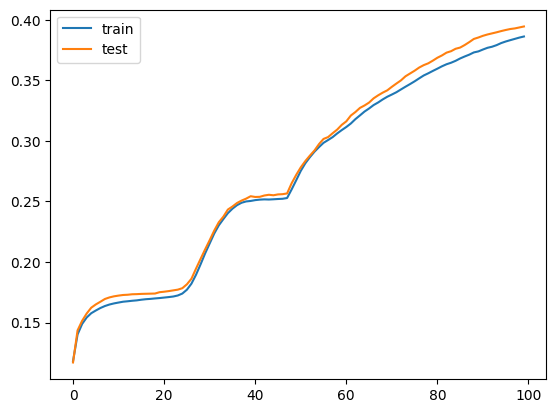

In [10]:
plot_acc(train_accs, test_accs)